1. Gerekli kütüphaneler

In [111]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Görselleştirme için ayar
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

2. Veriyi okuma

In [112]:
# Veri dosyasını oku
df = pd.read_csv("survey.csv")

print(f"📌 Veri boyutu: {df.shape[0]} satır, {df.shape[1]} sütun")

# İlk 5 satırı görüntüleyerek genel yapıya göz atalım
df.head()

📌 Veri boyutu: 1259 satır, 27 sütun


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,Male,United States,IN,NaN,No,No,Rarely,More than 1000,...,Dont know,Maybe,No,No,No,No,No,Dont know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Dont know,No,No,Some of them,Yes,Yes,Yes,Dont know,No,NaN


3. Aykırı değer kontrolü ve medyanla temizleme

3. 1. Yaş sütunu temizliği

🎂 Yaş - Minimum: -29, Maksimum: 329
🎯 Medyan yaş: 31.0
⚠️ Düzeltme yapılan aykırı yaş sayısı: 0
✅ Aykırı yaşlar medyan ile değiştirildi.
🎂 Yeni Yaş Aralığı: 15 - 72


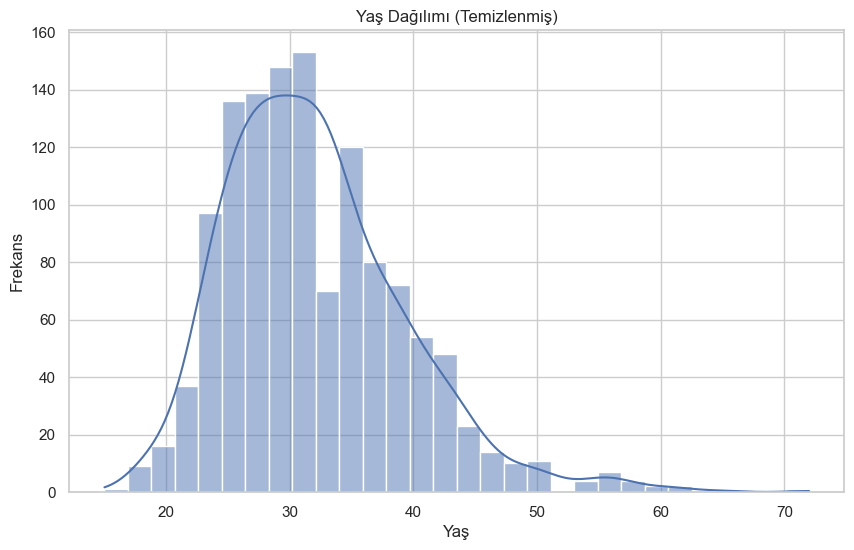

In [113]:
# Yaş sütununu kontrol edelim: 15 yaş altı ve 80 yaş üstü aykırı kabul edilsin
print(f"🎂 Yaş - Minimum: {df['Age'].min()}, Maksimum: {df['Age'].max()}")

# Aykırı yaşları tespit et ve medyan ile değiştir
median_age = df['Age'].median()
df.loc[(df['Age'] < 15) | (df['Age'] > 80), 'Age'] = median_age

print(f"🎯 Medyan yaş: {median_age}")

aykiri_sayisi = ((df['Age'] < 15) | (df['Age'] > 80)).sum()
print(f"⚠️ Düzeltme yapılan aykırı yaş sayısı: {aykiri_sayisi}")

print("✅ Aykırı yaşlar medyan ile değiştirildi.")
print(f"🎂 Yeni Yaş Aralığı: {df['Age'].min()} - {df['Age'].max()}")

sns.histplot(df["Age"], bins=30, kde=True)
plt.title("Yaş Dağılımı (Temizlenmiş)")
plt.xlabel("Yaş")
plt.ylabel("Frekans")
plt.show()

3. 2. Cinsiyet sütunu temizliği

🎭 Orijinal Gender değerleri:
Gender
Male              979
Female            252
Make                4
Male                3
Man                 2
Female              2
Agender             1
Malr                1
Mail                1
Female (cis)        1
queer               1
Female (trans)      1
msle                1
Enby                1
All                 1
Nah                 1
Femake              1
non-binary          1
queer/she/they      1
Male (CIS)          1
Mal                 1
maile               1
femail              1
Name: count, dtype: int64
🗑️ Silinen aykırı cinsiyet sayısı: 0

✅ Temizlenmiş Gender sütunu:
Gender
Male      988
Female    257
Name: count, dtype: int64


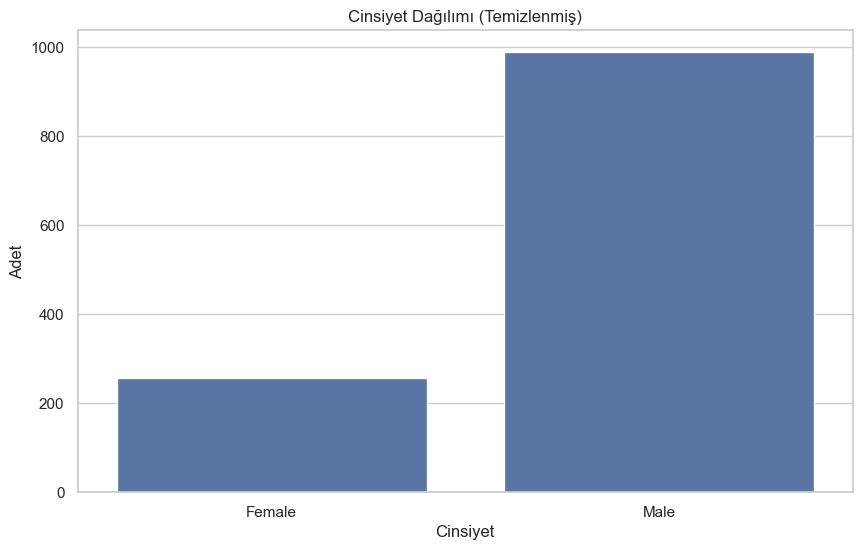

In [114]:
# Gender sütunundaki farklı değerleri görelim
print("🎭 Orijinal Gender değerleri:")
print(df["Gender"].value_counts())

# Fonksiyon: yalnızca Male ve Female ayır, diğerlerini NaN yap
def binary_gender(value):
    value = str(value).strip().lower()

    if value in ["male", "m", "man", "cis male", "cis man", "male-ish", "maile", "mal", "msle", "mail", "cis-male"]:
        return "Male"
    elif value in ["female", "f", "woman", "cis female", "female (cis)", "femake", "cis-female", "femail"]:
        return "Female"
    else:
        return pd.NA  # Diğerlerini NaN olarak işaretle

# Temizleme işlemi
df["Gender"] = df["Gender"].apply(binary_gender)

# Sadece Male ve Female kalan verilerle devam et
df = df[df["Gender"].isin(["Male", "Female"])]

print(f"🗑️ Silinen aykırı cinsiyet sayısı: {df['Gender'].isna().sum()}")

# Kontrol
print("\n✅ Temizlenmiş Gender sütunu:")
print(df["Gender"].value_counts())

sns.countplot(x="Gender", data=df)
plt.title("Cinsiyet Dağılımı (Temizlenmiş)")
plt.xlabel("Cinsiyet")
plt.ylabel("Adet")
plt.show()

3. 3. Zihinsel sağlık durumunun iş yaşamını ne ölçüde etkilediği sütunu temizliği

🛠 Orijinal 'work_interfere' değerleri:
work_interfere
Sometimes    455
NaN          263
Never        213
Rarely       172
Often        142
Name: count, dtype: int64

✅ Temizlenmiş 'work_interfere' sütunu:
work_interfere
Sometimes    718
Never        213
Rarely       172
Often        142
Name: count, dtype: int64


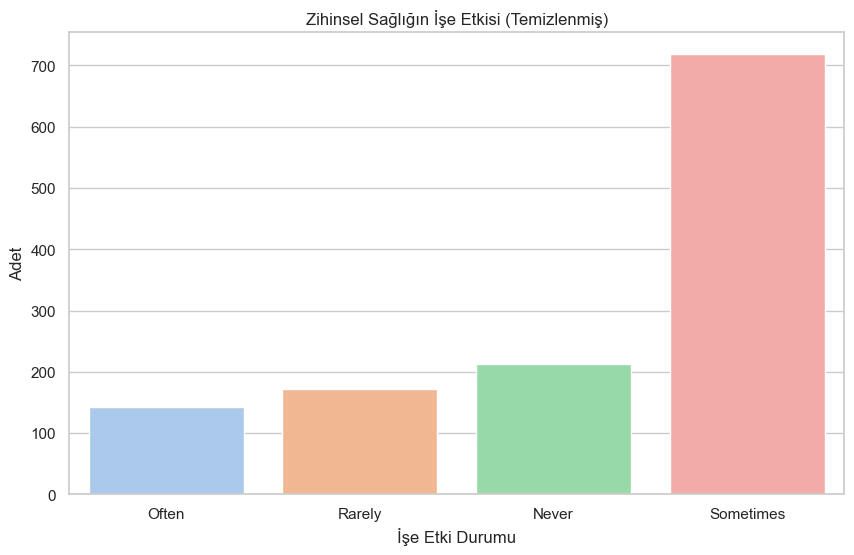

In [115]:
# Geçerli değerler
valid_work_interfere = ["Never", "Rarely", "Sometimes", "Often"]

# 🧐 Orijinal değerleri inceleyelim
print("🛠 Orijinal 'work_interfere' değerleri:")
print(df["work_interfere"].value_counts(dropna=False))

# 🎯 Hem geçersiz hem eksik (NaN) olanları NaN yap
df["work_interfere"] = df["work_interfere"].apply(
    lambda x: x if pd.notna(x) and x in valid_work_interfere else pd.NA
)

# ✅ Eksik olanları en sık geçen (mod) değerle doldur
most_common = df["work_interfere"].mode()[0]
df["work_interfere"] = df["work_interfere"].fillna(most_common)

# 🔍 Son kontrol
print("\n✅ Temizlenmiş 'work_interfere' sütunu:")
print(df["work_interfere"].value_counts())

# 🎨 Görselleştirme: 'work_interfere' sütunu dağılımı
sns.countplot(data=df, x="work_interfere", hue="work_interfere", palette="pastel", legend=False)
plt.title("Zihinsel Sağlığın İşe Etkisi (Temizlenmiş)")
plt.xlabel("İşe Etki Durumu")
plt.ylabel("Adet")
plt.show()

3. 4. Zihinsel sağlık sorunları nedeniyle işten izin almak kolay mı sütunu temizliği

🛠 Orijinal 'leave' değerleri:
leave
Dont know             559
Somewhat easy         261
Very easy             204
Somewhat difficult    125
Very difficult         96
Name: count, dtype: int64

✅ Temizlenmiş 'leave' sütunu:
leave
Somewhat easy         820
Very easy             204
Somewhat difficult    125
Very difficult         96
Name: count, dtype: int64


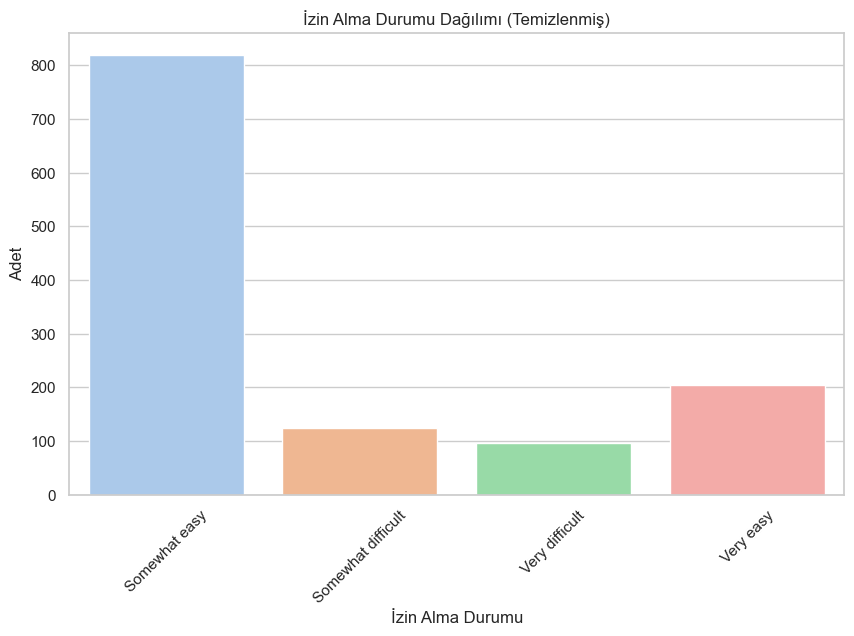

In [116]:
# Geçerli değerler
valid_leave = ["Very difficult", "Somewhat difficult", "Somewhat easy", "Very easy", "Don't know"]

# Mevcut değerleri gözlemleyelim
print("🛠 Orijinal 'leave' değerleri:")
print(df["leave"].value_counts(dropna=False))

# Temizleme işlemi
df["leave"] = df["leave"].where(df["leave"].isin(valid_leave), pd.NA)

# FutureWarning çözümü: inplace=False kullan, sonra atama yap
most_common_leave = df["leave"].mode()[0]
df["leave"] = df["leave"].fillna(most_common_leave)

# Kontrol
print("\n✅ Temizlenmiş 'leave' sütunu:")
print(df["leave"].value_counts())

# 🎨 'leave' Sütununun Dağılım Grafiği
sns.countplot(data=df, x="leave", hue="leave", palette="pastel", legend=False)
plt.title("İzin Alma Durumu Dağılımı (Temizlenmiş)")
plt.xlabel("İzin Alma Durumu")
plt.ylabel("Adet")
plt.xticks(rotation=45)
plt.show()

3. 5. Kişiye fayda sağlayan programlar sunuluyor mu sütunu temizliği

🛠 Orijinal 'benefits' değerleri:
benefits
Yes          471
Dont know    406
No           368
Name: count, dtype: int64

✅ Temizlenmiş 'benefits' değerleri:
benefits
Yes          471
Dont know    406
No           368
Name: count, dtype: int64


/var/folders/dm/hckhrzb5207cp2xy2c6ts38c0000gn/T/ipykernel_79788/2848156024.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="benefits", palette="pastel")


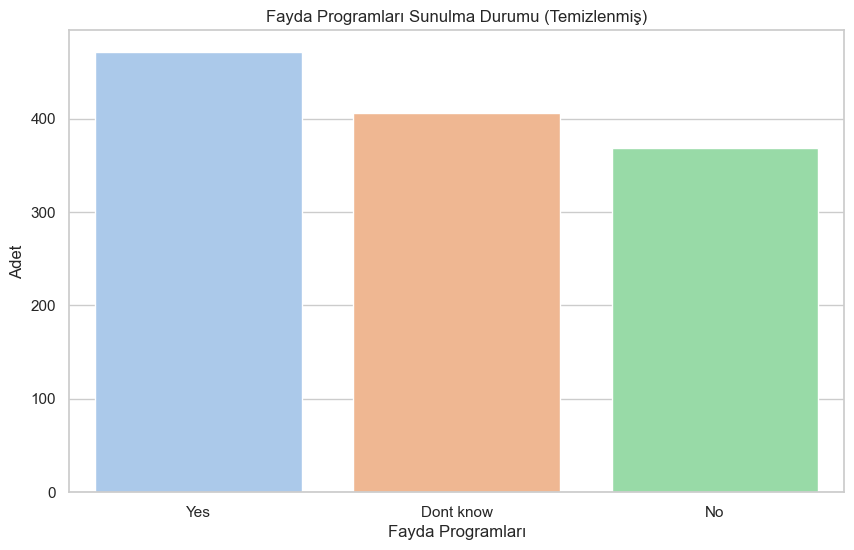

In [117]:
# 3.5. 'benefits' sütunu temizliği (düzgün ve 3 seçenek kalacak)

# Geçerli kategoriler
valid_benefits = ["Yes", "No", "Don't know"]

# Orijinal değerleri görelim
print("🛠 Orijinal 'benefits' değerleri:")
print(df["benefits"].value_counts(dropna=False))

# Küçük harfe çevirip boşlukları temizle → sonra uygun kategoriye eşle
def clean_benefits(value):
    if isinstance(value, str):
        value = value.strip().lower()
        if value in ["yes", "ye", "y"]:
            return "Yes"
        elif value in ["no", "n"]:
            return "No"
        elif value in ["dont know", "don't know", "do not know"]:
            return "Dont know"
    return pd.NA

df["benefits"] = df["benefits"].apply(clean_benefits)

# Eksikleri mod ile doldur (mod 3 seçenek arasında kalacak!)
most_common_benefit = df["benefits"].mode()[0]
df["benefits"] = df["benefits"].fillna(most_common_benefit)

# Kontrol
print("\n✅ Temizlenmiş 'benefits' değerleri:")
print(df["benefits"].value_counts())

sns.countplot(data=df, x="benefits", palette="pastel")
plt.title("Fayda Programları Sunulma Durumu (Temizlenmiş)")
plt.xlabel("Fayda Programları")
plt.ylabel("Adet")
plt.show()

3. 6. Zihinsel sağlık için anonim destek alabiliyor mu sütunu temizliği

🛠 Orijinal 'anonymity' değerleri:
anonymity
Dont know    809
Yes          372
No            64
Name: count, dtype: int64

✅ Temizlenmiş 'anonymity' değerleri:
anonymity
Dont know    809
Yes          372
No            64
Name: count, dtype: int64


/var/folders/dm/hckhrzb5207cp2xy2c6ts38c0000gn/T/ipykernel_79788/2124202701.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="anonymity", hue=None, palette="pastel")


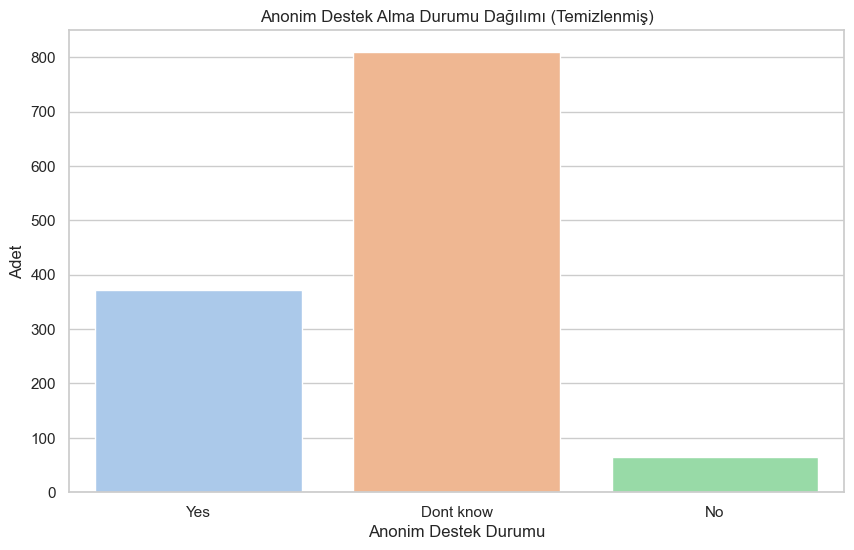

In [118]:
# Geçerli değerler
valid_anonymity = ["Yes", "No", "Don't know"]

# Orijinal değerleri görelim
print("🛠 Orijinal 'anonymity' değerleri:")
print(df["anonymity"].value_counts(dropna=False))

# Küçük harfe çevirip boşlukları temizle → uygun kategoriye eşle
def clean_anonymity(value):
    if isinstance(value, str):
        value = value.strip().lower().replace("’", "'").replace("‘", "'")  # farkları da yakala!
        if value in ["yes", "ye", "y"]:
            return "Yes"
        elif value in ["no", "n"]:
            return "No"
        elif value in ["dont know", "don't know", "do not know"]:
            return "Dont know"
    return pd.NA

# Temizleme işlemi
df["anonymity"] = df["anonymity"].apply(clean_anonymity)

# Eksikleri "Don't know" ile doldur
df["anonymity"] = df["anonymity"].fillna("Dont know")

# Kontrol
print("\n✅ Temizlenmiş 'anonymity' değerleri:")
print(df["anonymity"].value_counts())

# 🎨 Görselleştirme (uyarısız hali)
sns.countplot(data=df, x="anonymity", hue=None, palette="pastel")
plt.title("Anonim Destek Alma Durumu Dağılımı (Temizlenmiş)")
plt.xlabel("Anonim Destek Durumu")
plt.ylabel("Adet")
plt.show()

4. Veri temizliği

🧹 Temizlik sonrası veri şekli: (1245, 23)
🧹 Kalan sütunlar: ['Age', 'Gender', 'Country', 'family_history', 'treatment', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence']

✅ Eksik değer bulunmuyor.


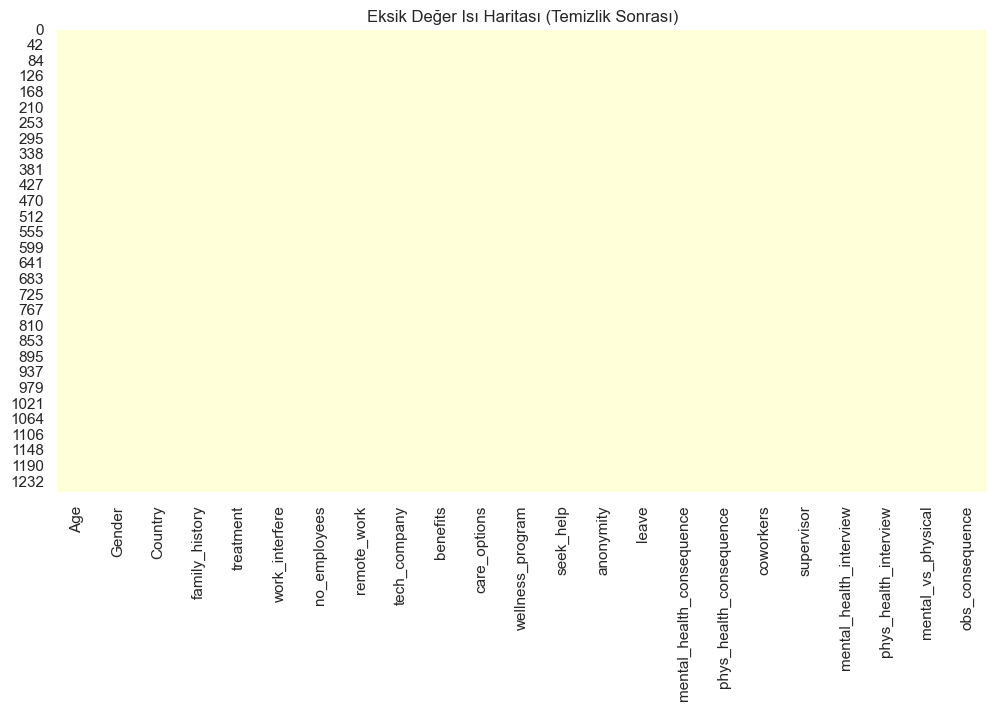

In [119]:
# 1️⃣ Gereksiz sütunları temizle
gereksiz_sutunlar = ["Timestamp", "self_employed", "comments", "state"]
df.drop(columns=gereksiz_sutunlar, inplace=True, errors="ignore")

# 2️⃣ Geçersiz yaşları filtrele
df = df[(df["Age"] >= 15) & (df["Age"] <= 80)]

# 3️⃣ Temizlik sonrası kontrol
print(f"🧹 Temizlik sonrası veri şekli: {df.shape}")
print(f"🧹 Kalan sütunlar: {df.columns.tolist()}")

# 4️⃣ Eksik değer kontrolü 🔎
missing = df.isnull().sum()
missing = missing[missing > 0]  # Sadece eksik olanları göster
if not missing.empty:
    print("\n⚠️ Eksik değer içeren sütunlar:")
    print(missing)
else:
    print("\n✅ Eksik değer bulunmuyor.")

# 🎨 6️⃣ Eksik değer oranları (Isı haritası ile)
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="YlGnBu")
plt.title("Eksik Değer Isı Haritası (Temizlik Sonrası)")
plt.show()

5. Encoding

In [120]:
# 🎯 Hedef ve özellikleri ayır
y = df["treatment"]
X = df.drop(columns=["treatment"])

# 🟢 Encoder'ları saklamak için sözlük oluştur
encoders = {}

# 🎯 Hedef (treatment) encode
le_target = LabelEncoder()
y = le_target.fit_transform(y)

# 🟢 Encoder'lara hedefin encoder'ını da kaydet
encoders["treatment"] = le_target

print("✅ X şekli:", X.shape)
print("✅ Hedef encode edildi. Sınıflar:", le_target.classes_)

✅ X şekli: (1245, 22)
✅ Hedef encode edildi. Sınıflar: ['No' 'Yes']


6. Kategorik Sütunlar için encoding

In [121]:
# 🟢 Kategorik sütunları tespit et (Age hariç!)
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
print(f"📂 Kategorik sütunlar: {categorical_cols}")

# 🟢 Her kategorik sütun için LabelEncoder uygula
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    encoders[col] = le  # Encoder'ı sakla

print("✅ Kategorik sütunlar encode edildi.")

📂 Kategorik sütunlar: ['Gender', 'Country', 'family_history', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence']
✅ Kategorik sütunlar encode edildi.


7. Train ve test olarak ayırma

In [122]:
from sklearn.model_selection import train_test_split

# Veriyi %70 eğitim, %30 test olarak ayıralım
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Eğitim verisi şekli:", X_train.shape)
print("✅ Test verisi şekli:", X_test.shape)

✅ Eğitim verisi şekli: (996, 22)
✅ Test verisi şekli: (249, 22)


8. Ölçeklendirme (StandartScaler)

In [123]:
from sklearn.preprocessing import StandardScaler

# Sayısal sütunları ölçeklemek için scaler
scaler = StandardScaler()

# Fit sadece eğitim verisinde yapılır!
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Ölçeklenmiş Eğitim Verisi:", X_train_scaled.shape)
print("✅ Ölçeklenmiş Test Verisi:", X_test_scaled.shape)

# Scaler'ı kaydedelim, deploy için lazım olacak
joblib.dump(scaler, "../deployment/mental_scaler.pkl")
print("💾 Scaler kaydedildi: 'deployment/mental_scaler.pkl'")

✅ Ölçeklenmiş Eğitim Verisi: (996, 22)
✅ Ölçeklenmiş Test Verisi: (249, 22)
💾 Scaler kaydedildi: 'deployment/mental_scaler.pkl'


9. Encoder Sözlüğü kaydı

In [124]:
# Daha önce oluşturduğumuz 'encoders' sözlüğünü kaydediyoruz
joblib.dump(encoders, "../deployment/mental_encoders.pkl")

print("💾 Encoder'lar başarıyla kaydedildi: 'deployment/mental_encoders.pkl'")

💾 Encoder'lar başarıyla kaydedildi: 'deployment/mental_encoders.pkl'


10. Train ve Test ön işlenmiş verilerin kaydı

In [125]:
# Pandas DataFrame'e geri dönüştür
train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
train_df["treatment"] = y_train

test_df = pd.DataFrame(X_test_scaled, columns=X.columns)
test_df["treatment"] = y_test

# CSV olarak kaydet
train_df.to_csv("normal/train_mental.csv", index=False)
test_df.to_csv("normal/test_mental.csv", index=False)

print("✅ Veriler başarıyla kaydedildi.")

✅ Veriler başarıyla kaydedildi.
